<a href="https://colab.research.google.com/github/ICBI/AIMAHEAD_GU/blob/main/Courses/ML_Concepts/Module_06_Natural_Language_Processing/Module_6_Natural_Language_Processing_03_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/ICBI/AIMAHEAD_GU_publicCourseData/main/AAlogo1.jpg" alt="Powered by" width="150"/>

#AI/ML for Healthcare Applications : Lab 6c Text Classification

Based on material from the Georgetown [Health Informatics and Data Science](https://healthinformatics.georgetown.edu) program and licensed under  [CC4.0](https://creativecommons.org/licenses/by/4.0/)


The aim of this notebook is to provide an hands-on demo of selecting model and tuning hyperparameters using sklearn.



In this lab, we will explore various ML approaches for text classification using the deep learning library: Keras

https://keras.io/

Pandas, Matplotlib and sklearn imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split



For this lab of text classification we will use the same adverse drug reaction dataset (with some minor changes) that we have used in the previous labs.

Read the csv file

In [ ]:
ade_file = "/content/drive/MyDrive/Work/HIDS_506_2024/Lecture9/data/ade_corpus_subset.csv"

In [ ]:
ade_df = pd.read_csv(ade_file)

In [ ]:
ade_df.head()

,pmid,sentence,label
0,11174414,"Severe rash, including the Stevens-Johnson syn...",1
1,12645965,Significant systemic manifestations are rare.,0
2,17172571,Chronic paroxysmal hemicrania (CPH) is a rare ...,0
3,16109609,Of twenty other patients in our practice who r...,0
4,15779196,A 74-year old white man was undergoing treatme...,0


In [ ]:
Counter(ade_df['label'])

Counter({1: 4272, 0: 7000})

Split into feature: text and outcome: label (1 evidence of adverse drug effect, 0: no evidence of adverse drug effect)

In [ ]:
X_docs = ade_df['sentence'].values
y = ade_df['label'].values

Split the dataset into training and test

In [ ]:
X_train_docs, X_test_docs, y_train, y_test = train_test_split(X_docs, y,
                                                    test_size=0.20,
                                                    random_state=42)

In [ ]:
X_train_docs.shape, X_test_docs.shape, y_train.shape, y_test.shape

((9017,), (2255,), (9017,), (2255,))

Distrubition of the outcome in the train and test set

In [ ]:
Counter(y_train), Counter(y_test)

(Counter({0: 5592, 1: 3425}), Counter({0: 1408, 1: 847}))

Check a sample

In [ ]:
X_train_docs[10]

'Prolonged severe cholestasis induced by oxacillin derivatives.'

In [ ]:
y_train[10]

1

## Recap: Shallow Classification using sklearn

We will use logistic regression with **tf-idf** feature representation as a baseline model

sklearn imports

In [ ]:
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [ ]:
#Helper function to train and test a sklearn model
def train_and_test(clf, X_train, y_train, X_test, y_test):
  clf.fit(X_train, y_train)
  y_test_pred = clf.predict(X_test)
  print(classification_report(y_test, y_test_pred))

We will build a pipeline where the first step is the vectorization of the input followed by

In [ ]:
lr_pipe = Pipeline([("vectorizer", TfidfVectorizer(min_df=5)),
                          ("clf", LogisticRegression(max_iter=300))])

In [ ]:
train_and_test(lr_pipe, X_train_docs, y_train, X_test_docs, y_test)

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1408
           1       0.81      0.68      0.74       847

    accuracy                           0.82      2255
   macro avg       0.81      0.79      0.80      2255
weighted avg       0.82      0.82      0.81      2255



## Text Classification using Neural Networks (NN)

In this section, we will use Keras (learn more about Keras: https://keras.io/), a popular deep learning library to train text classifiers.
We will discuss two approaches:

(1) NN with traditional bag-of-words (tf-idf) text representation

(2) NN with dense word embeddings representation

### NN with tf-idf

The Sequential model in keras is a linear stack of layers, where you can use the large variety of available layers in Keras. The most common layer is the Dense layer which is your regular densely connected neural network layer with all the weights and biases that you are already familiar with.

Let’s see if we can achieve some improvement to our previous logistic regression model.

Before we build our model, we need to know the input dimension of our feature vectors. This happens only in the first layer since the following layers can do automatic shape inference. In order to build the Sequential model, you can add layers one by one in order as follows:

**Vectorize** the train and test documents using the **tfidf vectorizer**

Notice the .toarray() after transform. This is not needed in sklearn models as it sparse representation frpom scipy but this optimized representation  is not good for keras. you simply have to transform it in a simple array.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer(min_df=5)
vectorizer.fit(X_train_docs)

X_train = vectorizer.transform(X_train_docs).toarray()
X_test  = vectorizer.transform(X_test_docs).toarray()

Shape of the training set?

In [ ]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
X_train.shape

(9017, 3518)

In [ ]:
X_train_docs[10]

'Prolonged severe cholestasis induced by oxacillin derivatives.'

In [ ]:
X_train.shape

(9017, 3518)

In [ ]:
X_train[10]

array([0., 0., 0., ..., 0., 0., 0.])

What does this represent?

**Define a NN network architecture**

Helper function to visualize training loss at each epoch

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

Number of features in the input layer : size of the vocabulary

In [ ]:
input_dim = X_train.shape[1]

In [ ]:
input_dim

3518

In [ ]:
input_dim

3518

NN architecture with 1 hidden layers of size 32

In [ ]:
nn_model = Sequential()
nn_model.add(Dense(32, input_dim=input_dim, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))

**Compile and view the NN architecture**

Before you can start with the training of the model, you need to configure the learning process. This is done with the .compile() method. This method specifies the optimizer and the loss function.

Additionally, you can add a list of metrics which can be later used for evaluation, but they do not influence the training. In this case, we want to use the binary cross entropy and the Adam optimizer you saw in the primer mentioned before. Keras also includes a handy .summary() function to give an overview of the model and the number of parameters available for training:

In [ ]:
input_dim

3518

(3518*32 + 32) + (32+1)

In [ ]:
nn_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                112608    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 112641 (440.00 KB)
Trainable params: 112641 (440.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Why 112641 params/weights in the first layer?

**Train model**

Define epochs, batch_size, and validation data

Since the training in neural networks is an iterative process, the training won’t just stop after it is done. You have to specify the number of iterations you want the model to be training. Those completed iterations are commonly called epochs. We want to run it for 100 epochs to be able to see how the training loss and accuracy are changing after each epoch.

Another parameter you have to your selection is the batch size. The batch size is responsible for how many samples we want to use in one epoch, which means how many samples are used in one forward/backward pass. This increases the speed of the computation as it need fewer epochs to run, but it also needs more memory, and the model may degrade with larger batch sizes. Since we have a small training set, we can leave this to a low batch size:

In [ ]:
X_train.shape, y_train.shape

((9017, 3518), (9017,))

In [ ]:
history = nn_model.fit(X_train, y_train,
                    epochs=7,
                    validation_split = 0.2,
                    batch_size=32)

Epoch 1/7
226/226 [==============================] - 2s 6ms/step - loss: 0.5972 - accuracy: 0.6857 - val_loss: 0.4983 - val_accuracy: 0.8076
Epoch 2/7
226/226 [==============================] - 1s 5ms/step - loss: 0.4084 - accuracy: 0.8425 - val_loss: 0.4083 - val_accuracy: 0.8232
Epoch 3/7
226/226 [==============================] - 1s 5ms/step - loss: 0.3102 - accuracy: 0.8819 - val_loss: 0.3868 - val_accuracy: 0.8298
Epoch 4/7
226/226 [==============================] - 1s 5ms/step - loss: 0.2554 - accuracy: 0.9067 - val_loss: 0.3876 - val_accuracy: 0.8320
Epoch 5/7
226/226 [==============================] - 2s 7ms/step - loss: 0.2181 - accuracy: 0.9214 - val_loss: 0.4039 - val_accuracy: 0.8237
Epoch 6/7
226/226 [==============================] - 2s 8ms/step - loss: 0.1898 - accuracy: 0.9344 - val_loss: 0.4196 - val_accuracy: 0.8187
Epoch 7/7
226/226 [==============================] - 1s 7ms/step - loss: 0.1676 - accuracy: 0.9463 - val_loss: 0.4431 - val_accuracy: 0.8171


*Visualize loss*

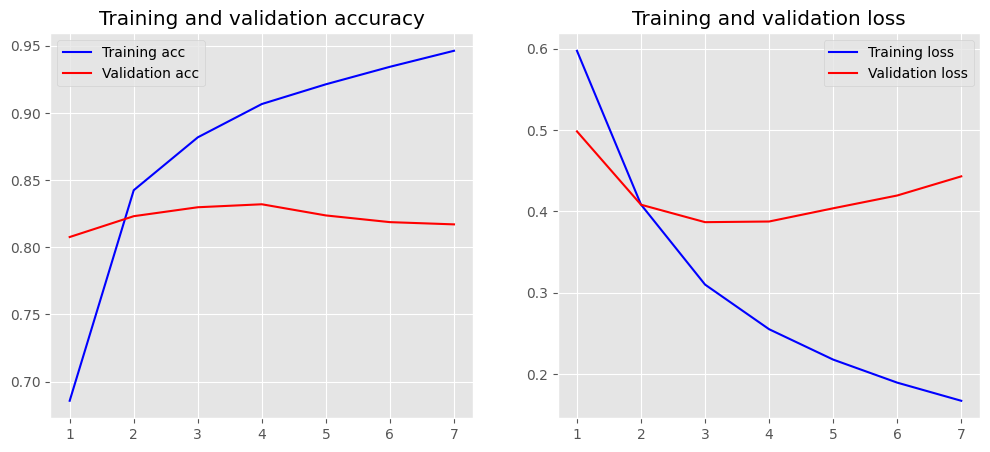

In [ ]:
plot_history(history)

Helper function to evaluate a trained Keras `model` on the test set

In [ ]:
def evaluate_keras_model(model, X_test, y_test):
  # Predicting the Test set results
  y_pred_prob = model.predict(X_test)
  y_pred = (y_pred_prob > 0.5).astype("int32")
  print(classification_report(y_test,y_pred))

In [ ]:
evaluate_keras_model(nn_model, X_test, y_test)

71/71 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1408
           1       0.74      0.74      0.74       847

    accuracy                           0.81      2255
   macro avg       0.79      0.79      0.79      2255
weighted avg       0.81      0.81      0.81      2255



### NN with Word Embeddings

In this section, we will define a network with an embedding layer, which maps each word in our input layer/vocab to a fixed dense word vector of some size (50, 100, 200 etc.).

Note that the word embeddings do not understand the text as a human would, but they rather map the statistical structure of the language used in the corpus. Their aim is to map semantic meaning into a geometric space. This geometric space is then called the **embedding space**.

How can you get such a word embedding? You have two options for this. One way is to train your word embeddings during the training of your neural network. The other way is by using pretrained word embeddings which you can directly use in your model. There you have the option to either leave these word embeddings unchanged during training or you train them also. We will use the first approach of learning the embeddings space as part of the training the classifier

**Tokenize text**

First step is to tokenize the text using `Tokenizer` utility class from Keras.

This vectorizes a text corpus into a list of integers. Each integer maps to a value in a dictionary that encodes the entire corpus, with the keys in the dictionary being the vocabulary terms themselves. You can add the parameter num_words, which is responsible for setting the size of the vocabulary. The most common `num_words` words will be then kept.

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(X_train_docs)

In [ ]:
X_train = tokenizer.texts_to_sequences(X_train_docs)
X_test = tokenizer.texts_to_sequences(X_test_docs)

In [ ]:
tokenizer.word_index

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

12139

The indexing is ordered after the most common words in the text, which you can see by the word the having the index 1. It is important to note that the index 0 is reserved and is not assigned to any word.

Unknown words (words that are not in the vocabulary) are denoted in Keras with word_count + 1 since they can also hold some information. We can see the index of each word by taking a look at the word_index dictionary of the Tokenizer object:

In [ ]:
tokenizer.word_index['induced']
#tokenizer.word_index['derivatives']

24

In [ ]:
tokenizer.word_index['oxacillin']

5471

Check how a document is encoded by the Keras tokenizer

Text

In [ ]:
X_train_docs[11]

'Marked QT prolongation and torsades de pointes secondary to acute ischemia in an elderly man taking dofetilide for atrial fibrillation: a cautionary tale.'

Encoded word index

In [ ]:
tokenizer.word_index['oxacillin']

5471

In [ ]:
len(X_train[12])

18

In [ ]:
tokenizer.word_index['oxacillin']

5471

What is the issue above?

**Text padding**

One problem that we have is that each text sequence has in most cases different length of words. To counter this, you can use pad_sequence() which simply pads the sequence of words with zeros. By default, it prepends zeros but we want to append them. Typically it does not matter whether you prepend or append zeros.

Additionally you would want to add a maxlen parameter to specify how long the sequences should be. This cuts sequences that exceed that number. This could be the maximum tokens in our training set or set by user. We will use the first method

In [ ]:
X_train_docs[11]

'Marked QT prolongation and torsades de pointes secondary to acute ischemia in an elderly man taking dofetilide for atrial fibrillation: a cautionary tale.'

In [ ]:
X_train[11]

[491,
 1000,
 1563,
 3,
 2128,
 832,
 1673,
 166,
 7,
 35,
 1674,
 6,
 18,
 632,
 102,
 177,
 3629,
 10,
 516,
 633,
 4]

In [ ]:
len(X_train[11])

21

Maximum num of tokens in our training set

In [ ]:
def get_max_doc_len(X_train):
  max_len = 0
  for doc in X_train:
    if len(doc) > max_len: max_len = len(doc)
  return max_len

In [ ]:
maxlen = get_max_doc_len(X_train)
maxlen

91

In [ ]:
from keras.utils import pad_sequences
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

After padding

In [ ]:
X_train[10]

array([ 311,   45, 1080,   24,   19, 3142,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=int32)

In [ ]:
print(X_train[10, :])

[ 311   45 1080   24   19 3142    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]


In [ ]:
print(X_train[11, :])

[ 491 1000 1563    3 2128  832 1673  166    7   35 1674    6   18  632
  102  177 3629   10  516  633    4    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]


**Keras Embedding Layer**

Notice that, at this point, our data is still hardcoded. We have not told Keras to learn a new embedding space through successive tasks. Now you can use the Embedding Layer of Keras which takes the previously calculated integers and maps them to a dense vector of the embedding.


After adding the embedding layer (say of size/dimension = d =  50), each tokenized word in our corpus will be represented by 50 dimension vector and hence each sentence in our corpus will be a 2D matrix of size vocab_size*50. How can we handle such a 2D input matrix in a neural network archticture. One approach is just to flatten the 2D (strech) to 1D layer and then plug it to any number of hidden Dense layers.


In order to do this you have to add a `Flatten` layer in between that prepares the sequential input for the Dense layer:

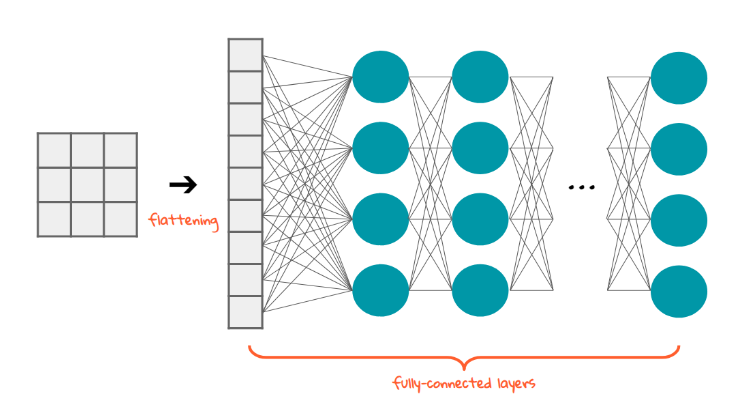

Let's define an word embedding size of 50.

In [ ]:
embedding_dim = 50

Create a **sequential** keras model

In [ ]:
model = Sequential()

Add an **embedding** layer

To define an embedding layer, we  will need the following parameters:

* input_dim: the size of the vocabulary
* output_dim: the size of the dense vector
* input_length: the length of the sequence

In [ ]:
vocab_size, maxlen

(12139, 91)

In [ ]:
from keras.layers import Embedding

In [ ]:
model.add(Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           input_length=maxlen))

Add the **flattening** layer

In [ ]:
from keras.layers import Flatten

In [ ]:
model.add(Flatten())

Complete the deep learning architecture using hidden layer(s) and output layer

In [ ]:
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

**Compile** the network

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 91, 50)            606950    
                                                                 
 flatten (Flatten)           (None, 4550)              0         
                                                                 
 dense_2 (Dense)             (None, 32)                145632    
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 752615 (2.87 MB)
Trainable params: 752615 (2.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Explain the number of params?**

**Train** the network

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_split = 0.2,
                    batch_size=32)

Epoch 1/10
226/226 [==============================] - 5s 16ms/step - loss: 0.5938 - accuracy: 0.6791 - val_loss: 0.4674 - val_accuracy: 0.7777
Epoch 2/10
226/226 [==============================] - 4s 15ms/step - loss: 0.3200 - accuracy: 0.8707 - val_loss: 0.4057 - val_accuracy: 0.8198
Epoch 3/10
226/226 [==============================] - 3s 12ms/step - loss: 0.1422 - accuracy: 0.9563 - val_loss: 0.4440 - val_accuracy: 0.8126
Epoch 4/10
226/226 [==============================] - 3s 12ms/step - loss: 0.0477 - accuracy: 0.9910 - val_loss: 0.5274 - val_accuracy: 0.8187
Epoch 5/10
226/226 [==============================] - 3s 12ms/step - loss: 0.0159 - accuracy: 0.9983 - val_loss: 0.5748 - val_accuracy: 0.8176
Epoch 6/10
226/226 [==============================] - 4s 17ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.6324 - val_accuracy: 0.8149
Epoch 7/10
226/226 [==============================] - 3s 13ms/step - loss: 0.0027 - accuracy: 0.9999 - val_loss: 0.6720 - val_accuracy: 0.8143

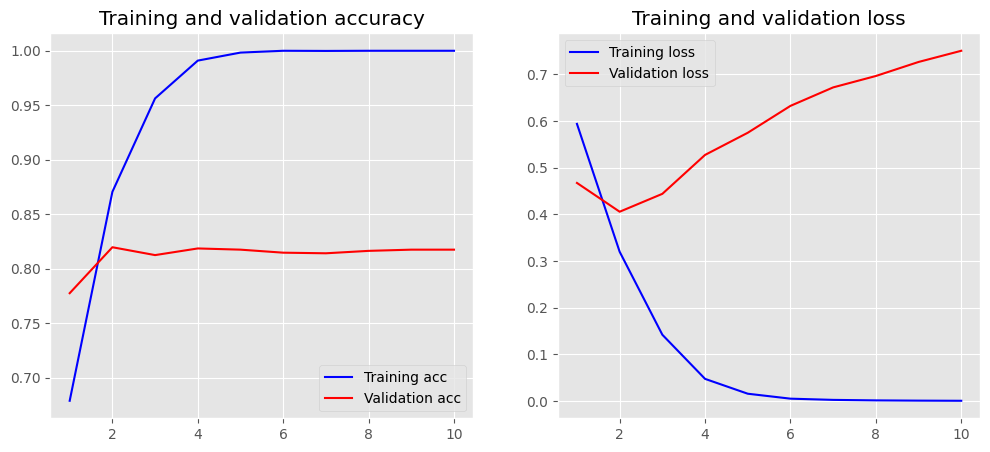

In [ ]:
plot_history(history)

**Evaluate**

In [ ]:
evaluate_keras_model(model, X_test, y_test)

71/71 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1408
           1       0.75      0.71      0.73       847

    accuracy                           0.80      2255
   macro avg       0.79      0.79      0.79      2255
weighted avg       0.80      0.80      0.80      2255



Try with dim=100?

Same code as above; but creation of the network in a single cell

In [ ]:
embedding_dim = 100

def create_embedding_model():
  model = Sequential()
  model.add(Embedding(input_dim=vocab_size,
                      output_dim=embedding_dim,
                      input_length=maxlen))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  #model.add(Dense(32, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
  return model

In [ ]:
model = create_embedding_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 91, 100)           1213900   
                                                                 
 flatten_1 (Flatten)         (None, 9100)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                582464    
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1796429 (6.85 MB)
Trainable params: 1796429 (6.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
X_train.shape

(9017, 91)

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_split = 0.2,
                    batch_size=64)

Epoch 1/10
113/113 [==============================] - 4s 34ms/step - loss: 2.9695e-04 - accuracy: 1.0000 - val_loss: 0.7754 - val_accuracy: 0.8121
Epoch 2/10
113/113 [==============================] - 3s 30ms/step - loss: 2.4417e-04 - accuracy: 1.0000 - val_loss: 0.7924 - val_accuracy: 0.8132
Epoch 3/10
113/113 [==============================] - 3s 30ms/step - loss: 2.0139e-04 - accuracy: 1.0000 - val_loss: 0.8081 - val_accuracy: 0.8126
Epoch 4/10
113/113 [==============================] - 4s 39ms/step - loss: 1.6451e-04 - accuracy: 1.0000 - val_loss: 0.8256 - val_accuracy: 0.8115
Epoch 5/10
113/113 [==============================] - 4s 31ms/step - loss: 1.3386e-04 - accuracy: 1.0000 - val_loss: 0.8410 - val_accuracy: 0.8121
Epoch 6/10
113/113 [==============================] - 3s 30ms/step - loss: 1.0973e-04 - accuracy: 1.0000 - val_loss: 0.8582 - val_accuracy: 0.8132
Epoch 7/10
113/113 [==============================] - 3s 29ms/step - loss: 9.0678e-05 - accuracy: 1.0000 - val_loss: 0

Keras/Tensor has GPU implementation of its model training process and we can take advantage of the GPU to speed up the training process

Below code contains parts of code from above (reading files, imports, tokenizations) as switching to GPU restarts the VM. This is not required, you can simply re-run required code blocks.

#### code blocks to be executed again for GPU switch

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

def evaluate_keras_model(model, X_test, y_test):
  # Predicting the Test set results
  y_pred_prob = model.predict(X_test)
  y_pred = (y_pred_prob > 0.5).astype("int32")
  print(classification_report(y_test,y_pred))

In [ ]:
ade_file = "/content/drive/MyDrive/Work/HIDS_506_2024/Lecture9/data/ade_corpus_subset.csv"
ade_df = pd.read_csv(ade_file)
X_docs = ade_df['sentence'].values
y = ade_df['label'].values
X_train_docs, X_test_docs, y_train, y_test = train_test_split(X_docs, y,
                                                    test_size=0.20,
                                                    random_state=42)

from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(X_train_docs)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(X_train_docs)
X_train = tokenizer.texts_to_sequences(X_train_docs)
X_test = tokenizer.texts_to_sequences(X_test_docs)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
def get_max_doc_len(X_train):
  max_len = 0
  for doc in X_train:
    if len(doc) > max_len: max_len = len(doc)
  return max_len

In [ ]:
maxlen = get_max_doc_len(X_train)
from keras.utils import pad_sequences
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Flatten

#### we can resume training with GPU

In [ ]:
embedding_dim = 100

def create_embedding_model():
  model = Sequential()
  model.add(Embedding(input_dim=vocab_size,
                      output_dim=embedding_dim,
                      input_length=maxlen))
  model.add(Flatten())
  #model.add(Dense(16, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
  return model

In [ ]:
model = create_embedding_model()
model.summary()

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_split = 0.2,
                    batch_size=32)

Epoch 1/10
226/226 [==============================] - 24s 80ms/step - loss: 0.5826 - accuracy: 0.6946 - val_loss: 0.4522 - val_accuracy: 0.8032
Epoch 2/10
226/226 [==============================] - 6s 28ms/step - loss: 0.2987 - accuracy: 0.8817 - val_loss: 0.4113 - val_accuracy: 0.8165
Epoch 3/10
226/226 [==============================] - 2s 10ms/step - loss: 0.1235 - accuracy: 0.9648 - val_loss: 0.4599 - val_accuracy: 0.8187
Epoch 4/10
226/226 [==============================] - 2s 10ms/step - loss: 0.0394 - accuracy: 0.9943 - val_loss: 0.5185 - val_accuracy: 0.8210
Epoch 5/10
226/226 [==============================] - 1s 6ms/step - loss: 0.0137 - accuracy: 0.9989 - val_loss: 0.5873 - val_accuracy: 0.8149
Epoch 6/10
226/226 [==============================] - 1s 6ms/step - loss: 0.0055 - accuracy: 0.9996 - val_loss: 0.6384 - val_accuracy: 0.8182
Epoch 7/10
226/226 [==============================] - 2s 8ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.6583 - val_accuracy: 0.8187
E

In [ ]:
plot_history(history)

In [ ]:
evaluate_keras_model(model, X_test, y_test)

This is typically a not very reliable way to work with sequential data as you can see in the performance. When working with sequential data you want to focus on methods that look at local and sequential information instead of absolute positional information.

Here is where Convolutional Neural Networks (CNN) comes in.

Note: Instead of Flatenning the embeddings layer you can using a `MaxPooling1D/AveragePooling1D` or a GlobalMaxPooling1D/GlobalAveragePooling1D layer after the embedding. You can think of the pooling layers as a way to downsample (a way to reduce the size of) the incoming feature vectors.

In the case of max pooling you take the maximum value of all features in the pool for each feature dimension. In the case of average pooling you take the average, but max pooling seems to be more commonly used as it highlights large values.

Add a pooling layer instead of Flatten and see if it captures sequential and local information i.e. performance increases or not.

### Convolutional Neural Networks (CNN)

Convolutional neural networks or also called convnets are one of the most exciting developments in machine learning in recent years.

They have revolutionized image classification and computer vision by being able to extract features from images and using them in neural networks. The properties that made them useful in image processing makes them also handy for sequence processing. You can imagine a CNN as a specialized neural network that is able to detect specific patterns.

If it is just another neural network, what differentiates it from what you have previously learned?

A CNN has hidden layers which are called convolutional layers. When you think of images, a computer has to deal with a two dimensional matrix of numbers and therefore you need some way to detect features in this matrix. These convolutional layers are able to detect edges, corners and other kinds of textures which makes them such a special tool. The convolutional layer consists of multiple filters which are slid across the image and are able to detect specific features.

This is the very core of the technique, the mathematical process of convolution. With each convolutional layer the network is able to detect more complex patterns. In the Feature Visualization by Chris Olah you can get a good intuition what these features can look like.

When you are working with sequential data, like text, you work with one dimensional convolutions, but the idea and the application stays the same. You still want to pick up on patterns in the sequence which become more complex with each added convolutional layer.

In the next figure you can see how such a convolution works. It starts by taking a patch of input features with the size of the filter kernel. With this patch you take the dot product of the multiplied weights of the filter. The one dimensional convnet is invariant to translations, which means that certain sequences can be recognized at a different position. This can be helpful for certain patterns in the text:

Now let’s have a look how you can use this network in Keras. Keras offers again various Convolutional layers which you can use for this task. The layer you’ll need is the Conv1D layer. This layer has again various parameters to choose from. The ones you are interested in for now are the number of filters, the kernel size, and the activation function. You can add this layer in between the Embedding layer and the GlobalMaxPool1D layer:

**Define sequential  CNNmodel**

In [ ]:
cnn_model = Sequential()

**Add Embedding Layer**

In [ ]:
embedding_dim = 50
cnn_model.add(Embedding(vocab_size,
                        embedding_dim,
                        input_length=maxlen))

**Add a Convolution Layer**

Also known as filters

In [ ]:
from keras.layers import Conv1D
from keras.layers import GlobalMaxPool1D

Adding 128 convolution filters of size 5

In [ ]:
cnn_model.add(Conv1D(128, 5, activation='relu'))

**Add the pooling layer**

In [ ]:
cnn_model.add(GlobalMaxPool1D())

**Add hidden (if any) and output layer**

In [ ]:
#Hidden layer
cnn_model.add(Dense(16, activation='relu'))

#Output layer
cnn_model.add(Dense(1, activation='sigmoid'))

**Compile model**

In [ ]:
vocab_size, maxlen

(12139, 91)

In [ ]:
cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 91, 50)            606950    
                                                                 
 conv1d (Conv1D)             (None, 87, 128)           32128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_2 (Dense)             (None, 16)                2064      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 641159 (2.45 MB)
Trainable params: 641159 (2.45 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

**Train and Evaluate the model**

In [ ]:
history = cnn_model.fit(X_train, y_train,
                    epochs=10,
                    validation_split = 0.2,
                    batch_size=32)

Epoch 1/10
226/226 [==============================] - 17s 63ms/step - loss: 0.5352 - accuracy: 0.7220 - val_loss: 0.4099 - val_accuracy: 0.8126
Epoch 2/10
226/226 [==============================] - 6s 25ms/step - loss: 0.2992 - accuracy: 0.8737 - val_loss: 0.3897 - val_accuracy: 0.8287
Epoch 3/10
226/226 [==============================] - 3s 13ms/step - loss: 0.1621 - accuracy: 0.9402 - val_loss: 0.4263 - val_accuracy: 0.8204
Epoch 4/10
226/226 [==============================] - 3s 11ms/step - loss: 0.0731 - accuracy: 0.9778 - val_loss: 0.5363 - val_accuracy: 0.8182
Epoch 5/10
226/226 [==============================] - 2s 7ms/step - loss: 0.0297 - accuracy: 0.9924 - val_loss: 0.6539 - val_accuracy: 0.8204
Epoch 6/10
226/226 [==============================] - 2s 9ms/step - loss: 0.0118 - accuracy: 0.9975 - val_loss: 0.7517 - val_accuracy: 0.8165
Epoch 7/10
226/226 [==============================] - 1s 6ms/step - loss: 0.0032 - accuracy: 0.9999 - val_loss: 0.8218 - val_accuracy: 0.8187
E

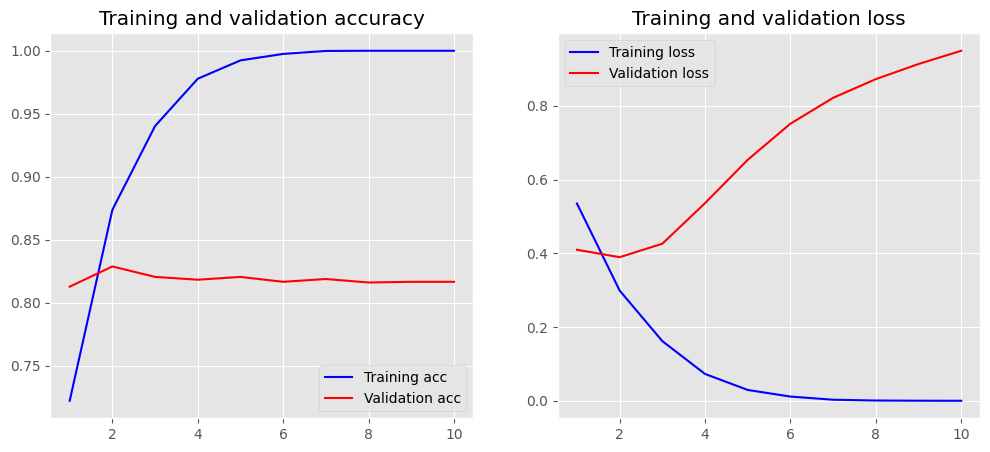

In [ ]:
plot_history(history)

In [ ]:
evaluate_keras_model(cnn_model, X_test, y_test)

71/71 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1408
           1       0.75      0.73      0.74       847

    accuracy                           0.80      2255
   macro avg       0.79      0.79      0.79      2255
weighted avg       0.80      0.80      0.80      2255



**CNN with different parameter**

Same code as above but wrapped the creation of the CNN model in a function

In [ ]:
dropout = 0.5
embedding_dim = 100

def create_model_cnn():
  model = Sequential()
  model.add(Embedding(input_dim=vocab_size,
                      output_dim=embedding_dim,
                      input_length=maxlen))

  model.add(Conv1D(128, 3, activation='relu'))
  model.add(GlobalMaxPool1D())

  model.add(Dropout(dropout))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [ ]:
model = create_model_cnn()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 91, 100)           1213900   
                                                                 
 conv1d_1 (Conv1D)           (None, 89, 128)           38528     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                      

In [ ]:
EPOCHS = 10
BATCH_SIZE = 32
model = create_model_cnn()
history = model.fit(X_train, y_train, epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_split = 0.2)

Epoch 1/10
226/226 [==============================] - 13s 47ms/step - loss: 0.6041 - accuracy: 0.6772 - val_loss: 0.4673 - val_accuracy: 0.7910
Epoch 2/10
226/226 [==============================] - 3s 15ms/step - loss: 0.4092 - accuracy: 0.8246 - val_loss: 0.4006 - val_accuracy: 0.8104
Epoch 3/10
226/226 [==============================] - 2s 9ms/step - loss: 0.2684 - accuracy: 0.8960 - val_loss: 0.4085 - val_accuracy: 0.8193
Epoch 4/10
226/226 [==============================] - 3s 12ms/step - loss: 0.1835 - accuracy: 0.9332 - val_loss: 0.5055 - val_accuracy: 0.8254
Epoch 5/10
226/226 [==============================] - 2s 7ms/step - loss: 0.1155 - accuracy: 0.9579 - val_loss: 0.6130 - val_accuracy: 0.8016
Epoch 6/10
226/226 [==============================] - 2s 10ms/step - loss: 0.0874 - accuracy: 0.9707 - val_loss: 0.7047 - val_accuracy: 0.8110
Epoch 7/10
226/226 [==============================] - 1s 7ms/step - loss: 0.0587 - accuracy: 0.9820 - val_loss: 0.8070 - val_accuracy: 0.8121
E

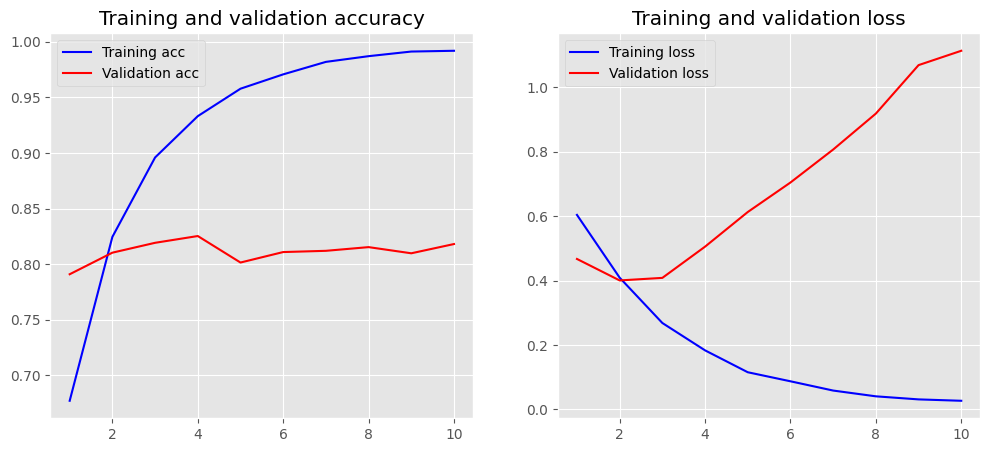

In [ ]:
plot_history(history)

In [ ]:
evaluate_keras_model(model, X_test, y_test)

71/71 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1408
           1       0.73      0.70      0.71       847

    accuracy                           0.79      2255
   macro avg       0.78      0.77      0.77      2255
weighted avg       0.79      0.79      0.79      2255



**Early Stop**

This parameter in Keras help stop training when a monitored metric has stopped improving (typically validation loss) indicative of overfitting

Assuming the goal of a training is to minimize the loss. With this, the metric to be monitored would be 'loss', and mode would be 'min'. A model.fit() training loop will check at end of every epoch whether the loss is no longer decreasing, considering the min_delta and patience if applicable. Once it's found no longer decreasing, model.stop_training is marked True and the training terminates.

Create an early stop callback

In [ ]:
import tensorflow as tf

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
EPOCHS = 10
BATCH_SIZE = 32
model = create_model_cnn()
history = model.fit(X_train, y_train, epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_split = 0.2,
                    callbacks=[callback])

Epoch 1/10
226/226 [==============================] - 12s 48ms/step - loss: 0.6056 - accuracy: 0.6753 - val_loss: 0.4686 - val_accuracy: 0.7844
Epoch 2/10
226/226 [==============================] - 3s 13ms/step - loss: 0.4036 - accuracy: 0.8255 - val_loss: 0.4100 - val_accuracy: 0.8160
Epoch 3/10
226/226 [==============================] - 2s 9ms/step - loss: 0.2740 - accuracy: 0.8934 - val_loss: 0.4417 - val_accuracy: 0.8027
Epoch 4/10
226/226 [==============================] - 2s 10ms/step - loss: 0.1805 - accuracy: 0.9362 - val_loss: 0.4890 - val_accuracy: 0.8182
Epoch 5/10
226/226 [==============================] - 2s 8ms/step - loss: 0.1300 - accuracy: 0.9562 - val_loss: 0.5617 - val_accuracy: 0.8143


Exception ignored in: <function _xla_gc_callback at 0x79b99c426560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


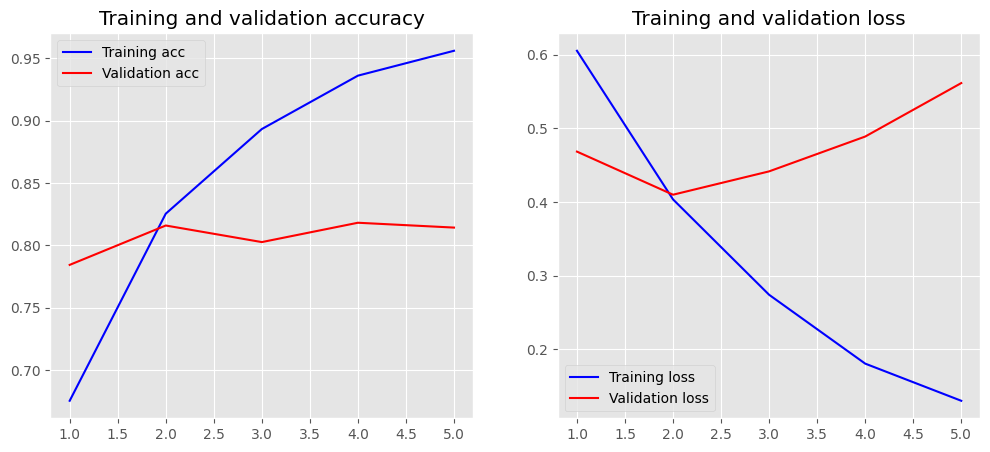

In [ ]:
plot_history(history)

In [ ]:
evaluate_keras_model(model, X_test, y_test)

71/71 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1408
           1       0.74      0.75      0.74       847

    accuracy                           0.81      2255
   macro avg       0.79      0.79      0.79      2255
weighted avg       0.81      0.81      0.81      2255



**Performance on test set improved with less training: Early stop**

**The END** <br>
**Authors: Dr. Samir Gupta, Dr. Matthew McCoy & ICBI AIM-AHEAD Team**

<img src="https://raw.githubusercontent.com/ICBI/AIMAHEAD_GU_publicCourseData/main/HIDSLOGO.AA1.jpg" alt="Powered by" width="500"/>